In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.activations import relu, softmax, sigmoid, swish
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing import image

2022-12-21 13:48:30.226198: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
datagenerator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    horizontal_flip=True,
    rotation_range=20,
    vertical_flip=True,
    width_shift_range=0.1,
    #featurewise_center=True,
    #samplewise_center=True,
    #samplewise_std_normalization=True,
    brightness_range=[0.90,1.25],
    #fill_mode='nearest'
)

In [3]:
# load and iterate training dataset
train_data = datagenerator.flow_from_directory('/local/data1/chash345/train', 
    class_mode='binary',
    target_size=(224, 224), 
    batch_size=32, 
    shuffle=True,
    color_mode='rgb'
)


# load and iterate validation dataset
val_data = datagenerator.flow_from_directory('/local/data1/chash345/valid', 
    class_mode='binary',
    target_size=(224, 224),
    batch_size=32, 
    shuffle=False,
    color_mode='rgb'
)


# load and iterate test dataset
test_data = datagenerator.flow_from_directory('/local/data1/chash345/test', 
    class_mode='binary',
    target_size=(224, 224),
    batch_size=1, 
    shuffle=False,
    color_mode='rgb'
)

Found 2600 images belonging to 2 classes.
Found 870 images belonging to 2 classes.
Found 864 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The dimensions of the image are 224 pixels width and 224 pixels height, one single color channel.
The maximum pixel value is 151.0610 and the minimum is -123.6800
The mean value of the pixels is -23.1977 and the standard deviation is 88.1978


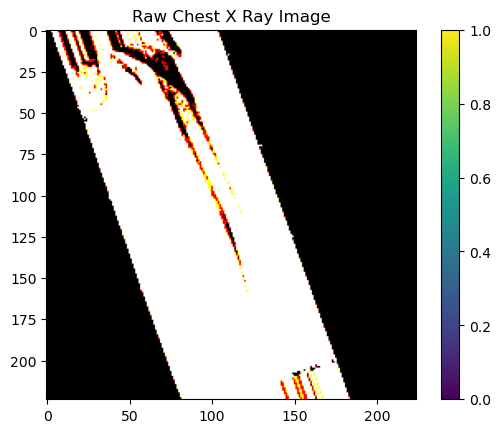

In [59]:
#sns.set_style('white')
generated_image, label = train_data.__getitem__(20)
plt.imshow(generated_image[7])

plt.colorbar()
plt.title('Raw Chest X Ray Image')

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height, one single color channel.")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

In [60]:
generated_image.shape

(32, 224, 224, 3)

In [61]:
pre_trained_model_resnet152 = ResNet152(input_shape=(224,224,3),
                                include_top=False,
                                weights="imagenet")

In [62]:
# Some weights in later layers are unfreezed
for layer in pre_trained_model_resnet152.layers:
    layer.trainable=False

tf.random.set_seed(150)

model = tf.keras.models.Sequential([
    pre_trained_model_resnet152,
    GlobalAveragePooling2D(),    
    Dense(512,activation="relu"),
    Dropout(0.4),
    Dense(256,activation="relu"),
    Dropout(0.4),
    Dense(128, activation='swish'),  
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=['accuracy'])

In [63]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 7, 7, 2048)        58370944  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 59,485,825
Trainable params: 1,114,881
Non-trainable params: 58,370,944
__________________________________

In [64]:
from sklearn.utils import class_weight
weights = class_weight.compute_class_weight(class_weight= 'balanced', y =train_data.classes, classes=np.unique(train_data.classes))
dict_weights = {0: weights[0], 1:weights[1]}
dict_weights

In [66]:
history = model.fit( train_data, 
validation_data= val_data, 
epochs= 10, 
verbose=1, 
class_weight=dict_weights
)

Epoch 1/8
82/82 [==============================] - 415s 5s/step - loss: 5120182495234195.0000 - accuracy: 0.6457 - val_loss: nan - val_accuracy: 0.4241
Epoch 2/8
82/82 [==============================] - 403s 5s/step - loss: 0.6879 - accuracy: 0.6578 - val_loss: 0.6746 - val_accuracy: 0.7989
Epoch 3/8
82/82 [==============================] - 403s 5s/step - loss: 0.6700 - accuracy: 0.8013 - val_loss: 0.6569 - val_accuracy: 0.7989
Epoch 4/8
82/82 [==============================] - 402s 5s/step - loss: 0.6538 - accuracy: 0.7905 - val_loss: 0.6405 - val_accuracy: 0.7989
Epoch 5/8
82/82 [==============================] - 403s 5s/step - loss: 0.6349 - accuracy: 0.8071 - val_loss: 0.6253 - val_accuracy: 0.7989
Epoch 6/8
82/82 [==============================] - 405s 5s/step - loss: 0.6212 - accuracy: 0.7998 - val_loss: 0.6109 - val_accuracy: 0.7989
Epoch 7/8
82/82 [==============================] - 405s 5s/step - loss: 0.6097 - accuracy: 0.7916 - val_loss: 0.5975 - val_accuracy: 0.7989
Epoch 8/

In [68]:
model = model.save('saved_model')


864/864 [==============================] - 151s 175ms/step - loss: 0.5848 - accuracy: 0.7998


[0.5848277807235718, 0.7997685074806213]

In [4]:
reconstructed_model = keras.models.load_model("saved_model")

2022-12-21 13:48:49.951680: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-12-21 13:48:49.954399: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-12-21 13:48:50.020747: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-21 13:48:50.021142: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.755GHz coreCount: 38 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2022-12-21 13:48:50.021195: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-12-21 13:48:50.163971: I tensorflow/stream_executor/platform

In [5]:
predcited_classes = reconstructed_model.predict_classes(test_data)

/home/chash345/.conda/envs/research/lib/python3.9/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
2022-12-21 13:50:08.461330: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-12-21 13:50:08.462322: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3492035000 Hz
2022-12-21 13:50:10.734852: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-12-2

In [6]:
predicted_probs = reconstructed_model.predict(test_data)

In [7]:
# %%
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, auc

# %%
fpr, tpr, thresholds = roc_curve(test_data.classes, predcited_classes)

In [8]:
# %%
roc_auc_score(test_data.classes, predicted_probs )


0.9862518089725036

In [9]:
# %%
roc_auc_score(test_data.classes, predcited_classes )

0.5

In [10]:
roc_auc = auc(fpr, tpr)

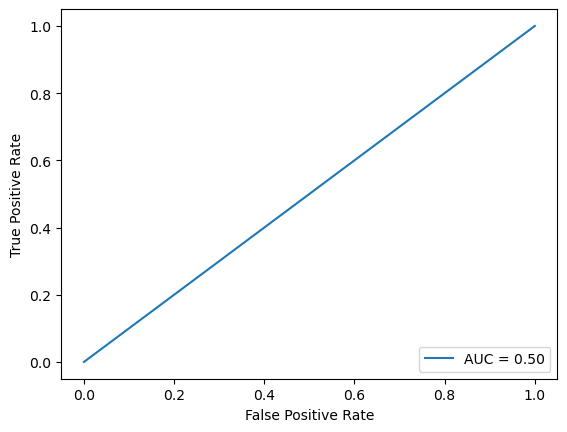

In [11]:
display = RocCurveDisplay(fpr=fpr,tpr=tpr, roc_auc=roc_auc)
display.plot()
plt.show()